# (19) df: lca + ista

**Motivation**: Device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def sc_extract_info(fname: str):
    type, lamb, lr, iter, seed = fname.split('_')
    if type == 'fista':
        type = 'ista'
        lr = lr.split(':')[-1]
    else:
        lr = lr.split('-')[1]
    info = dict(
        type=str(type),
        lr=float(lr),
        iter=int(iter.split('-')[1]),
        lamb=float(lamb.split(':')[-1]),
        seed=int(seed.split('.')[0].split('-')[1]),
    )
    return info


def analyze_fits_sc(fits: str):
    df_sc = collections.defaultdict(list)
    for fname in tqdm(fits, ncols=60):
        vals = sc_extract_info(fname)
        if fname in best_sc_seeds:
            quality = 'best'
        elif fname.replace('.npz', '') in selected_sc:
            quality = 'good'
        else:
            quality = 'bad'
        vals['quality'] = quality
        # load
        run = run = np.load(pjoin(root[vals['type']], fname))
        y, z = run['recons'], run['activations']
        # recon
        vals['mse_map'] = tr.model.loss_recon(
            y=tr.to(y.reshape(-1, 1, 16, 16)),
            x=tr.dl_vld.dataset.tensors[0],
        ).mean().item()
        # sparse score
        lifetime, population, _ = sparse_score(
            z.astype('float32'))
        vals['lifetime'] = lifetime.mean()
        vals['population'] = population.mean()
        # add values
        for k, v in vals.items():
            df_sc[k].append(v)
    
    df_sc = pd.DataFrame(df_sc)
    return df_sc

## Device

In [3]:
device_idx = 3
device = f'cuda:{device_idx}'

from analysis.final import sort_fits, analyze_fits

## vld data

In [4]:
tr = TrainerVAE(
    MODEL_CLASSES['poisson'](CFG_CLASSES['poisson'](dataset='DOVES', save=False)),
    ConfigTrainVAE(),
    device=device,
)

## Load SC results

In [5]:
root = {
    'lca': add_home('Dropbox/chkpts/LCA'),
    'ista': add_home('Dropbox/chkpts/ISTA'),
}
print({
    k: len(os.listdir(v)) for
    k, v in root.items()
})

{'lca': 330, 'ista': 329}

### selected fits (look good)

In [6]:
selected_sc = os.listdir(pjoin(fig_base_dir, 'selected_ista_lca'))
selected_sc = [f.replace('.png', '') for f in sorted(selected_sc)]
print(len(selected_sc))

183

### best fits (dict plotted along with 4 x VAEs)

In [7]:
best_sc = [
    'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-1',
    'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-1',
]

In [8]:
fits_lca = sorted(os.listdir(root['lca']))
fits_ista = sorted(os.listdir(root['ista']))

In [9]:
best_sc_seeds = []
for target_string in best_sc:
    pattern = target_string.rsplit('_', 1)[0] + '_seed-\d+'
    matches = [s for s in fits_lca + fits_ista if re.match(pattern, s)]
    best_sc_seeds.extend(matches)
print(best_sc_seeds)

[
    'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-1.npz',
    'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-2.npz',
    'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-3.npz',
    'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-4.npz',
    'lca_lamb-0.05:0.7:0.1_lr-0.01_iter-900_seed-5.npz',
    'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-1.npz',
    'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-2.npz',
    'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-3.npz',
    'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-4.npz',
    'fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-5.npz'
]

### Get both + concat + save

In [10]:
df_sc = pd.concat([
    analyze_fits_sc(fits_lca),
    analyze_fits_sc(fits_ista),
]).reset_index(drop=True)

save_obj(
    obj=df_sc,
    file_name='df_sc',
    save_dir=tmp_dir,
    verbose=True,
    mode='df',
)

100%|█████████████████████| 329/329 [01:46<00:00,  3.10it/s]


[PROGRESS] 'df_sc.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [11]:
df_sc['quality'].value_counts()

quality
bad     476
good    173
best     10
Name: count, dtype: int64

## Load df, analyze

In [12]:
df_sc = pjoin(tmp_dir, 'df_sc.df')
df_sc = pd.read_pickle(df_sc)

<Axes: xlabel='mse', ylabel='lifetime'>

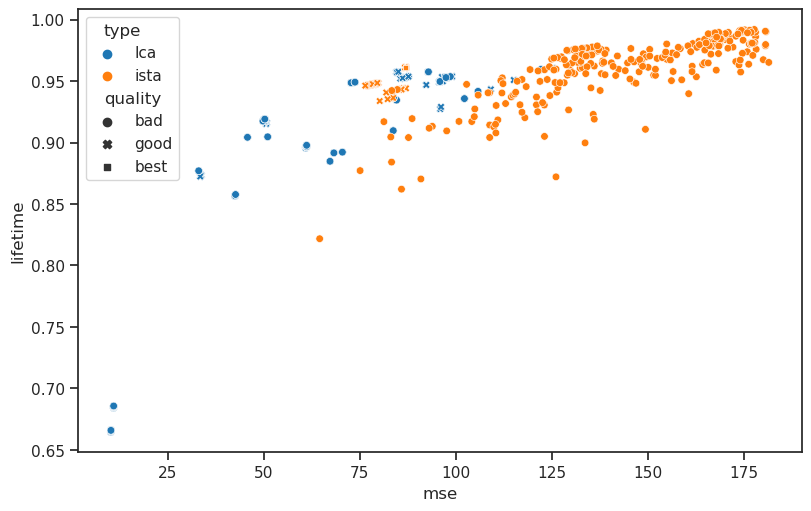

In [14]:
fig, ax = create_figure(1, 1, (8, 5))
sns.scatterplot(data=df_sc, x='mse', y='lifetime', hue='type', style='quality', s=30)

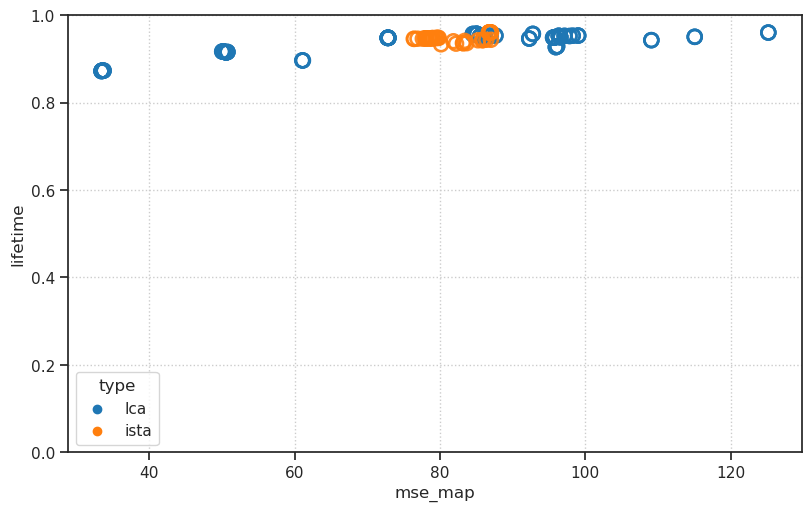

In [13]:
fig, ax = create_figure(1, 1, (8, 5))
sns.scatterplot(
    data=df_sc.loc[df_sc['quality'] == 'good'],
    x='mse_map', y='lifetime', hue='type',
    s=100, alpha=0.9,
)
for artist in ax.collections:
    c = artist.get_facecolor()
    artist.set_edgecolor(c)
    artist.set_facecolor('none')
    artist.set_lw(1.9)
ax.set(ylim=(0, 1))
ax.grid()
plt.show()

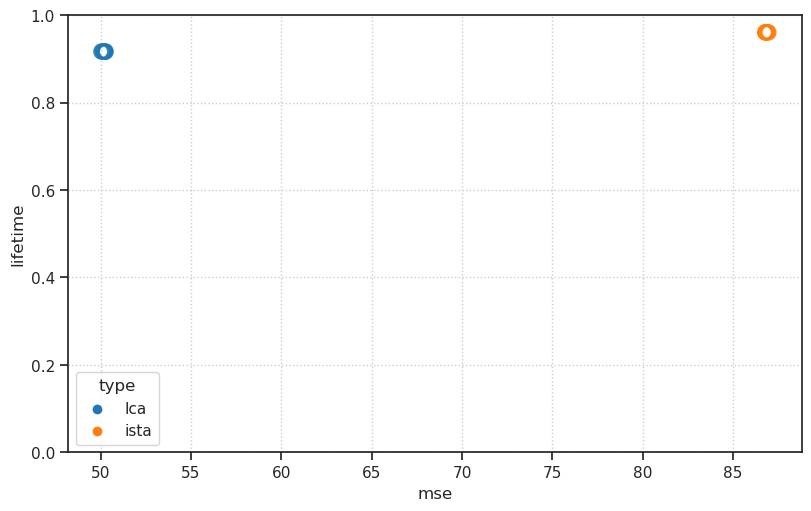

In [15]:
fig, ax = create_figure(1, 1, (8, 5))
sns.scatterplot(
    data=df_sc.loc[df_sc['quality'] == 'best'],
    x='mse', y='lifetime', hue='type',
    s=100, alpha=0.9,
)
for artist in ax.collections:
    c = artist.get_facecolor()
    artist.set_edgecolor(c)
    artist.set_facecolor('none')
    artist.set_lw(1.9)
ax.set(ylim=(0, 1))
ax.grid()
plt.show()